<a href="https://colab.research.google.com/github/marcinmichalsmolen/zum_nlp/blob/main/ZUM2NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ZUM_NLP Marcin Smoleń s23429

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

!python -m pip install spacy==3.2.0 -q
!python -m spacy download pl_core_news_md

Import bibliotek i wczytanie zbioru tweetów z mojego serwera

In [3]:
import numpy as np
import pandas as pd
import string
import json
import re

DATASET_COLUMNS=['Id', 'text',]
DATASET_ENCODING = "UTF-8"
from pandas.core import frame
df=pd.read_json(path_or_buf='http://77.55.209.58/zum2/tweets.json',encoding=DATASET_ENCODING,typ=frame)
df

2012-03-04 10:17:01.616861185    [VIDEO] Premier: Przedstawiamy kompleksowy pla...
2011-10-23 17:01:55.487666178                                                     
2015-01-17 05:04:47.280467978       Nie no to jest Złoto 🤣 https://t.co/Rxrlckriug
2012-07-29 04:00:49.879867394    Czekam, kiedy Polski Związek Hodowców Gołębi P...
2013-02-08 14:30:29.840453643    Eksperci przewidują, że szczepionki przeciwko ...
                                                       ...                        
2009-10-18 20:27:38.570440704    Coraz więcej osób z personelu medycznego pisze...
2015-12-22 03:44:55.948939266    Najwyższa od marca liczba nowych zgonów na Cov...
2014-01-13 00:03:49.843283971                Czechs' loss. https://t.co/MdZP4V1B0k
2012-01-06 11:20:47.311114241    Kilka lat temy Pfizer zapłacił kilkadziesiat m...
2011-11-26 01:37:09.843283997                                                     
Length: 462124, dtype: object

In [4]:
from pandas.io.formats.info import DataFrameInfo
N = 10
df.sample(N) 
# Konwertuje dane do formatu Dataframe
data=pd.DataFrame(data=df)
data.index=pd.to_numeric(data.index)
data['label'] = None
data.columns=['text','label']
data.index.unique()
data

,text,label
1330856221616861185,[VIDEO] Premier: Przedstawiamy kompleksowy pla...,None
1319389315487666178,,None
1421471087280467978,Nie no to jest Złoto 🤣 https://t.co/Rxrlckriug,None
1343534449879867394,"Czekam, kiedy Polski Związek Hodowców Gołębi P...",None
1360333829840453643,"Eksperci przewidują, że szczepionki przeciwko ...",None
...,...,...
1255897658570440704,Coraz więcej osób z personelu medycznego pisze...,None
1450755895948939266,Najwyższa od marca liczba nowych zgonów na Cov...,None
1389571429843283971,Czechs' loss. https://t.co/MdZP4V1B0k,None
1325848847311114241,Kilka lat temy Pfizer zapłacił kilkadziesiat m...,None


Import bibliotek

In [5]:
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
from nltk.stem import WordNetLemmatizer
import spacy
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

from textblob import TextBlob

In [6]:
def get_tweet_sentiment(tweet):
        '''
        Utility function to classify sentiment of passed tweet
        using textblob's sentiment method
        '''
        # create TextBlob object of passed tweet text
        analysis = TextBlob(tweet)
        # Ustawienie sentymentu
        if analysis.sentiment.polarity > 0:
            return 'pozytywny'
        else:
            return 'negatywny'

In [7]:
for ind in data.index:
     data['label'][ind] = get_tweet_sentiment(data['text'][ind])

In [11]:
data

,text,label
1330856221616861185,[VIDEO] Premier: Przedstawiamy kompleksowy pla...,negatywny
1319389315487666178,,negatywny
1421471087280467978,Nie no to jest Złoto 🤣 https://t.co/Rxrlckriug,negatywny
1343534449879867394,"Czekam, kiedy Polski Związek Hodowców Gołębi P...",negatywny
1360333829840453643,"Eksperci przewidują, że szczepionki przeciwko ...",negatywny
...,...,...
1255897658570440704,Coraz więcej osób z personelu medycznego pisze...,negatywny
1450755895948939266,Najwyższa od marca liczba nowych zgonów na Cov...,negatywny
1389571429843283971,Czechs' loss. https://t.co/MdZP4V1B0k,negatywny
1325848847311114241,Kilka lat temy Pfizer zapłacił kilkadziesiat m...,negatywny


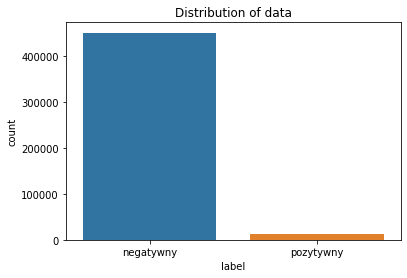

In [12]:
data.groupby('label').nunique()
ax = data.groupby('label').count().plot(kind='bar', title='Distribution of data', legend=False)
ax.set_xticklabels(['pozytywny','negatywny'], rotation=0)
sns.countplot(x='label', data=data)

In [13]:
data=data[['text','label']] 
pd.options.mode.chained_assignment = None
data_pos = data[data['label'].isin(['pozytywny'])]
data_neg = data[data['label'].isin(['negatywny'])]
print(data_neg)
print(data_pos)
dataset = pd.concat([data_pos, data_neg])
dataset= dataset.applymap(lambda s:s.lower() if type(s) == str else s)
dataset.sample(100)

                                                                  text      label
1330856221616861185  [VIDEO] Premier: Przedstawiamy kompleksowy pla...  negatywny
1319389315487666178                                                     negatywny
1421471087280467978     Nie no to jest Złoto 🤣 https://t.co/Rxrlckriug  negatywny
1343534449879867394  Czekam, kiedy Polski Związek Hodowców Gołębi P...  negatywny
1360333829840453643  Eksperci przewidują, że szczepionki przeciwko ...  negatywny
...                                                                ...        ...
1255897658570440704  Coraz więcej osób z personelu medycznego pisze...  negatywny
1450755895948939266  Najwyższa od marca liczba nowych zgonów na Cov...  negatywny
1389571429843283971              Czechs' loss. https://t.co/MdZP4V1B0k  negatywny
1325848847311114241  Kilka lat temy Pfizer zapłacił kilkadziesiat m...  negatywny
1322271429843283997                                                     negatywny

[450503 rows x 

,text,label
1310553023878397952,@ankaho235 @owapaw @szumowskilukasz musiał się...,negatywny
1260500017602859010,@dominikkucinsk trzeci świat śmieje się z test...,negatywny
1299283652715610113,ponad 7 mln zakażeń #covid19 w #amerykałacińsk...,negatywny
1248238729208254465,to jest piękne ☺️ https://t.co/6atcabrwqa,negatywny
1406637126498893835,"tajwan nareszcie dostał 2,5 mln szczepionek z ...",negatywny
...,...,...
1409193534033469444,"spotkania w hotelach, na łodziach i festiwale ...",negatywny
1339286937866219521,,negatywny
1444221270829248519,@mz_gov_pl polska covid-19 [dzień 578]\n\n~zak...,negatywny
1330713225575493633,nikon z50 ❤️ \n\n#nikon #camara #moon #z50 #ph...,negatywny


Wczytywanie zbioru stopwords do odszumienia danych i wyświetlenie jego zawartości

In [15]:
nlp = spacy.load('pl_core_news_md')
stopwordlist = nlp.Defaults.stop_words
print(stopwordlist)

{'do', 'cała', 'powinni', 'cały', 'gdzies', 'oto', 'powinien', 'mozliwe', 'dwaj', 'twoi', 'ani', 'iv', 'czy', 'wielu', 'ktoś', 'zeby', 'rowniez', 'moim', 'wiele', 'jezeli', 'ten', 'dosc', 'nasze', 'jej', 'będę', 'znow', 'mimo', 'sobą', 'jakis', 'ktorego', 'można', 'im', 'jakos', 'i', 'tak', 'ze', 'totobą', 'duzo', 'poza', 'dlaczego', 'sobie', 'są', 'dokąd', 'byc', 'to', 'przecież', 'vi', 'niech', 'totez', 'bowiem', 'no', 'zapewne', 'w', 'ktokolwiek', 'jedna', 'zaden', 'dużo', 'na', 'tam', 'ktory', 'ty', 'wy', 'tys', 'nia', 'nad', 'aczkolwiek', 'gdyz', 'będą', 'dzisiaj', 'naszych', 'często', 'dobrze', 'znów', 'natomiast', 'ale', 'bardzo', 'sie', 'zostal', 'od', 'wam', 'cie', 'które', 'iż', 'żadne', 'będzie', 'między', 'kilka', 'mu', 'mamy', 'te', 'xii', 'ktorym', 'bedzie', 'żaden', 'jakaś', 'wasz', 'inny', 'nam', 'o', 'mają', 'wasza', 'jednakże', 'ja', 'moze', 'bede', 'po', 'wasi', 'którego', 'właśnie', 'więcej', 'ix', 'przede', 'xi', 'ktora', 'sposob', 'czasem', 'zadnych', 'juz', 'ktor

In [ ]:
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stopwordlist])
for ind in dataset.index:
     dataset['text'][ind] = cleaning_stopwords(dataset['text'][ind])
dataset.sample(10)
  

In [ ]:
dataset['text'].head()


In [ ]:
punctuations_list = string.punctuation
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)

for ind in dataset.index:
     dataset['text'][ind] = cleaning_punctuations(dataset['text'][ind])

dataset.sample(10)

In [ ]:
def cleaning_repeating_char(text):
    return re.sub(r'(.)1+', r'1', text)
for ind in dataset.index:
     dataset['text'][ind] = cleaning_repeating_char(dataset['text'][ind])
dataset.sample(10)

In [ ]:
def cleaning_URLs(data):
    return re.sub('((www.[^s]+)|(https[^s]+))',' ',data)

for ind in dataset.index:
     dataset['text'][ind] = cleaning_URLs(dataset['text'][ind])

dataset.sample(10)

In [ ]:
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)
    
for ind in dataset.index:
     dataset['text'][ind] = cleaning_numbers(dataset['text'][ind])

dataset.sample(10)

Tokenizacja

In [ ]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'w+')
dataset['text'] = dataset['text'].apply(tokenizer.tokenize)
dataset['text'].head()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.05, random_state =42)

In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectorizer.fit(X_train)
print('No. of feature_words: ', len(vectorizer.get_feature_names()))

In [ ]:
X_train = vectorizer.transform(X_train)
X_test  = vectorizer.transform(X_test)


In [ ]:
def model_Evaluate(model):
  # Predykcja danych na danych testowych
  y_pred = model.predict(X_test)

  # Wyświetlenie metryk ewaluacji na podstawie predykcji i ground truth (faktycznych etykiet)
  print(classification_report(y_test, y_pred))

  # Obliczamy i wyświetlamy confusion matrix
  cf_matrix = confusion_matrix(y_test, y_pred)
  categories = ['negatywny','pozytywny']
  group_names n= ['True Neg','False Pos', 'False Neg','True Pos']
  group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
  labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names, group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
  xticklabels = categories, yticklabels = categories)
  plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
  plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
  plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)
  return y_pred

In [ ]:
BNBmodel = BernoulliNB()
BNBmodel.fit(X_train, y_train)
y_pred1 = BNBmodel.predict(X_test)
print(y_pred1)

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_pred1)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

In [ ]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)
y_pred2 = SVCmodel.predict(X_test)

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred2)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

In [ ]:
LRmodel = LogisticRegression(max_iter = 1000)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)
y_pred3 = LRmodel.predict(X_test)

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred3)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()